# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment


# 2. Load Data

In [10]:
data = pd.read_csv('../Dataset/GlobalTemperatures.csv')
data = data.drop(columns='dt')
data

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3187,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063


# 3. Initial Analysis

### 3.1. Metadata

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 8 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   LandAverageTemperature                     3192 non-null   float64
 1   LandAverageTemperatureUncertainty          3192 non-null   float64
 2   LandMaxTemperature                         3192 non-null   float64
 3   LandMaxTemperatureUncertainty              3192 non-null   float64
 4   LandMinTemperature                         3192 non-null   float64
 5   LandMinTemperatureUncertainty              3192 non-null   float64
 6   LandAndOceanAverageTemperature             3192 non-null   float64
 7   LandAndOceanAverageTemperatureUncertainty  3192 non-null   float64
dtypes: float64(8)
memory usage: 199.6 KB


In [17]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LandAverageTemperature,3192.0,8.374731,4.373064,-2.080,4.32775,8.584500,12.538750,19.021
LandAverageTemperatureUncertainty,3192.0,0.938468,1.094376,0.034,0.18700,0.394500,1.413250,7.880
LandMaxTemperature,3192.0,14.350601,3.404137,5.900,12.26600,14.350601,16.749000,21.320
LandMaxTemperatureUncertainty,3192.0,0.479782,0.460672,0.044,0.20675,0.479782,0.479782,4.373
LandMinTemperature,3192.0,2.743595,3.282695,-5.407,0.95950,2.743595,4.669000,9.715
LandMinTemperatureUncertainty,3192.0,0.431849,0.352167,0.045,0.23100,0.431849,0.431849,3.498
LandAndOceanAverageTemperature,3192.0,15.212566,1.006406,12.475,14.76550,15.212566,15.819500,17.611
LandAndOceanAverageTemperatureUncertainty,3192.0,0.128532,0.058126,0.042,0.10800,0.128532,0.131000,0.457


In [18]:
data.isnull().sum()

LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64

In [14]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 11


### 3.2. Columns Processing

In [15]:
data = data.fillna(data.mean())

In [19]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty']
Categorical Columns : []


In [24]:
def converttemp(x):
    x = (x * 1.8) + 32
    return float(x)

def change_unit(data):
    for column in categorical_columns:
        data[column] = data[column].progress_apply(converttemp)
    return data

data = change_unit(data)

In [79]:
# def change_columns_to_numerical(data):
#     LE = LabelEncoder()

#     for column in categorical_columns:
#         data[column] = LE.fit_transform(data[column])
#         data[column] = data[column].astype(int)
#         # print(f'{column} : {LE.classes_}') 
#     return data

# data = change_columns_to_numerical(data)

### 3.3. EDA

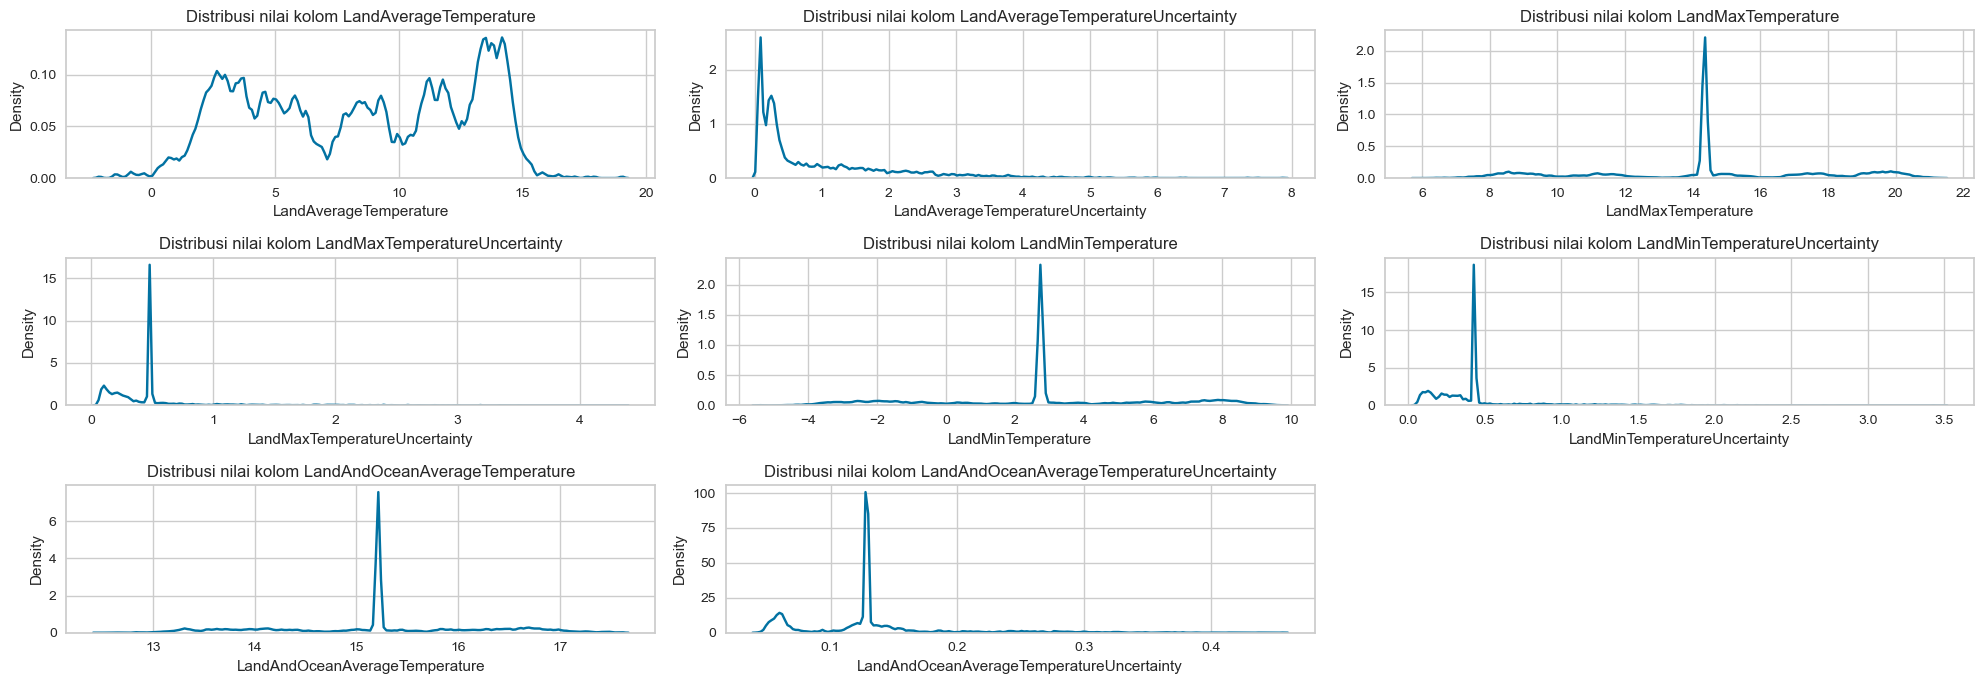

In [20]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# num_cols = 3
# num_rows = math.ceil(len(numerical_columns) / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# for i, column in enumerate(numerical_columns):
#     row = i // num_cols
#     col = i % num_cols
#     sns.kdeplot(data=data, x=column, hue="Owner", 
#                 fill=True, alpha=.2, palette="YlOrRd", 
#                 common_norm=False, ax=axes[row, col],
#                 warn_singular=False)\
#         .set_title(column)

# for i in range(len(numerical_columns), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

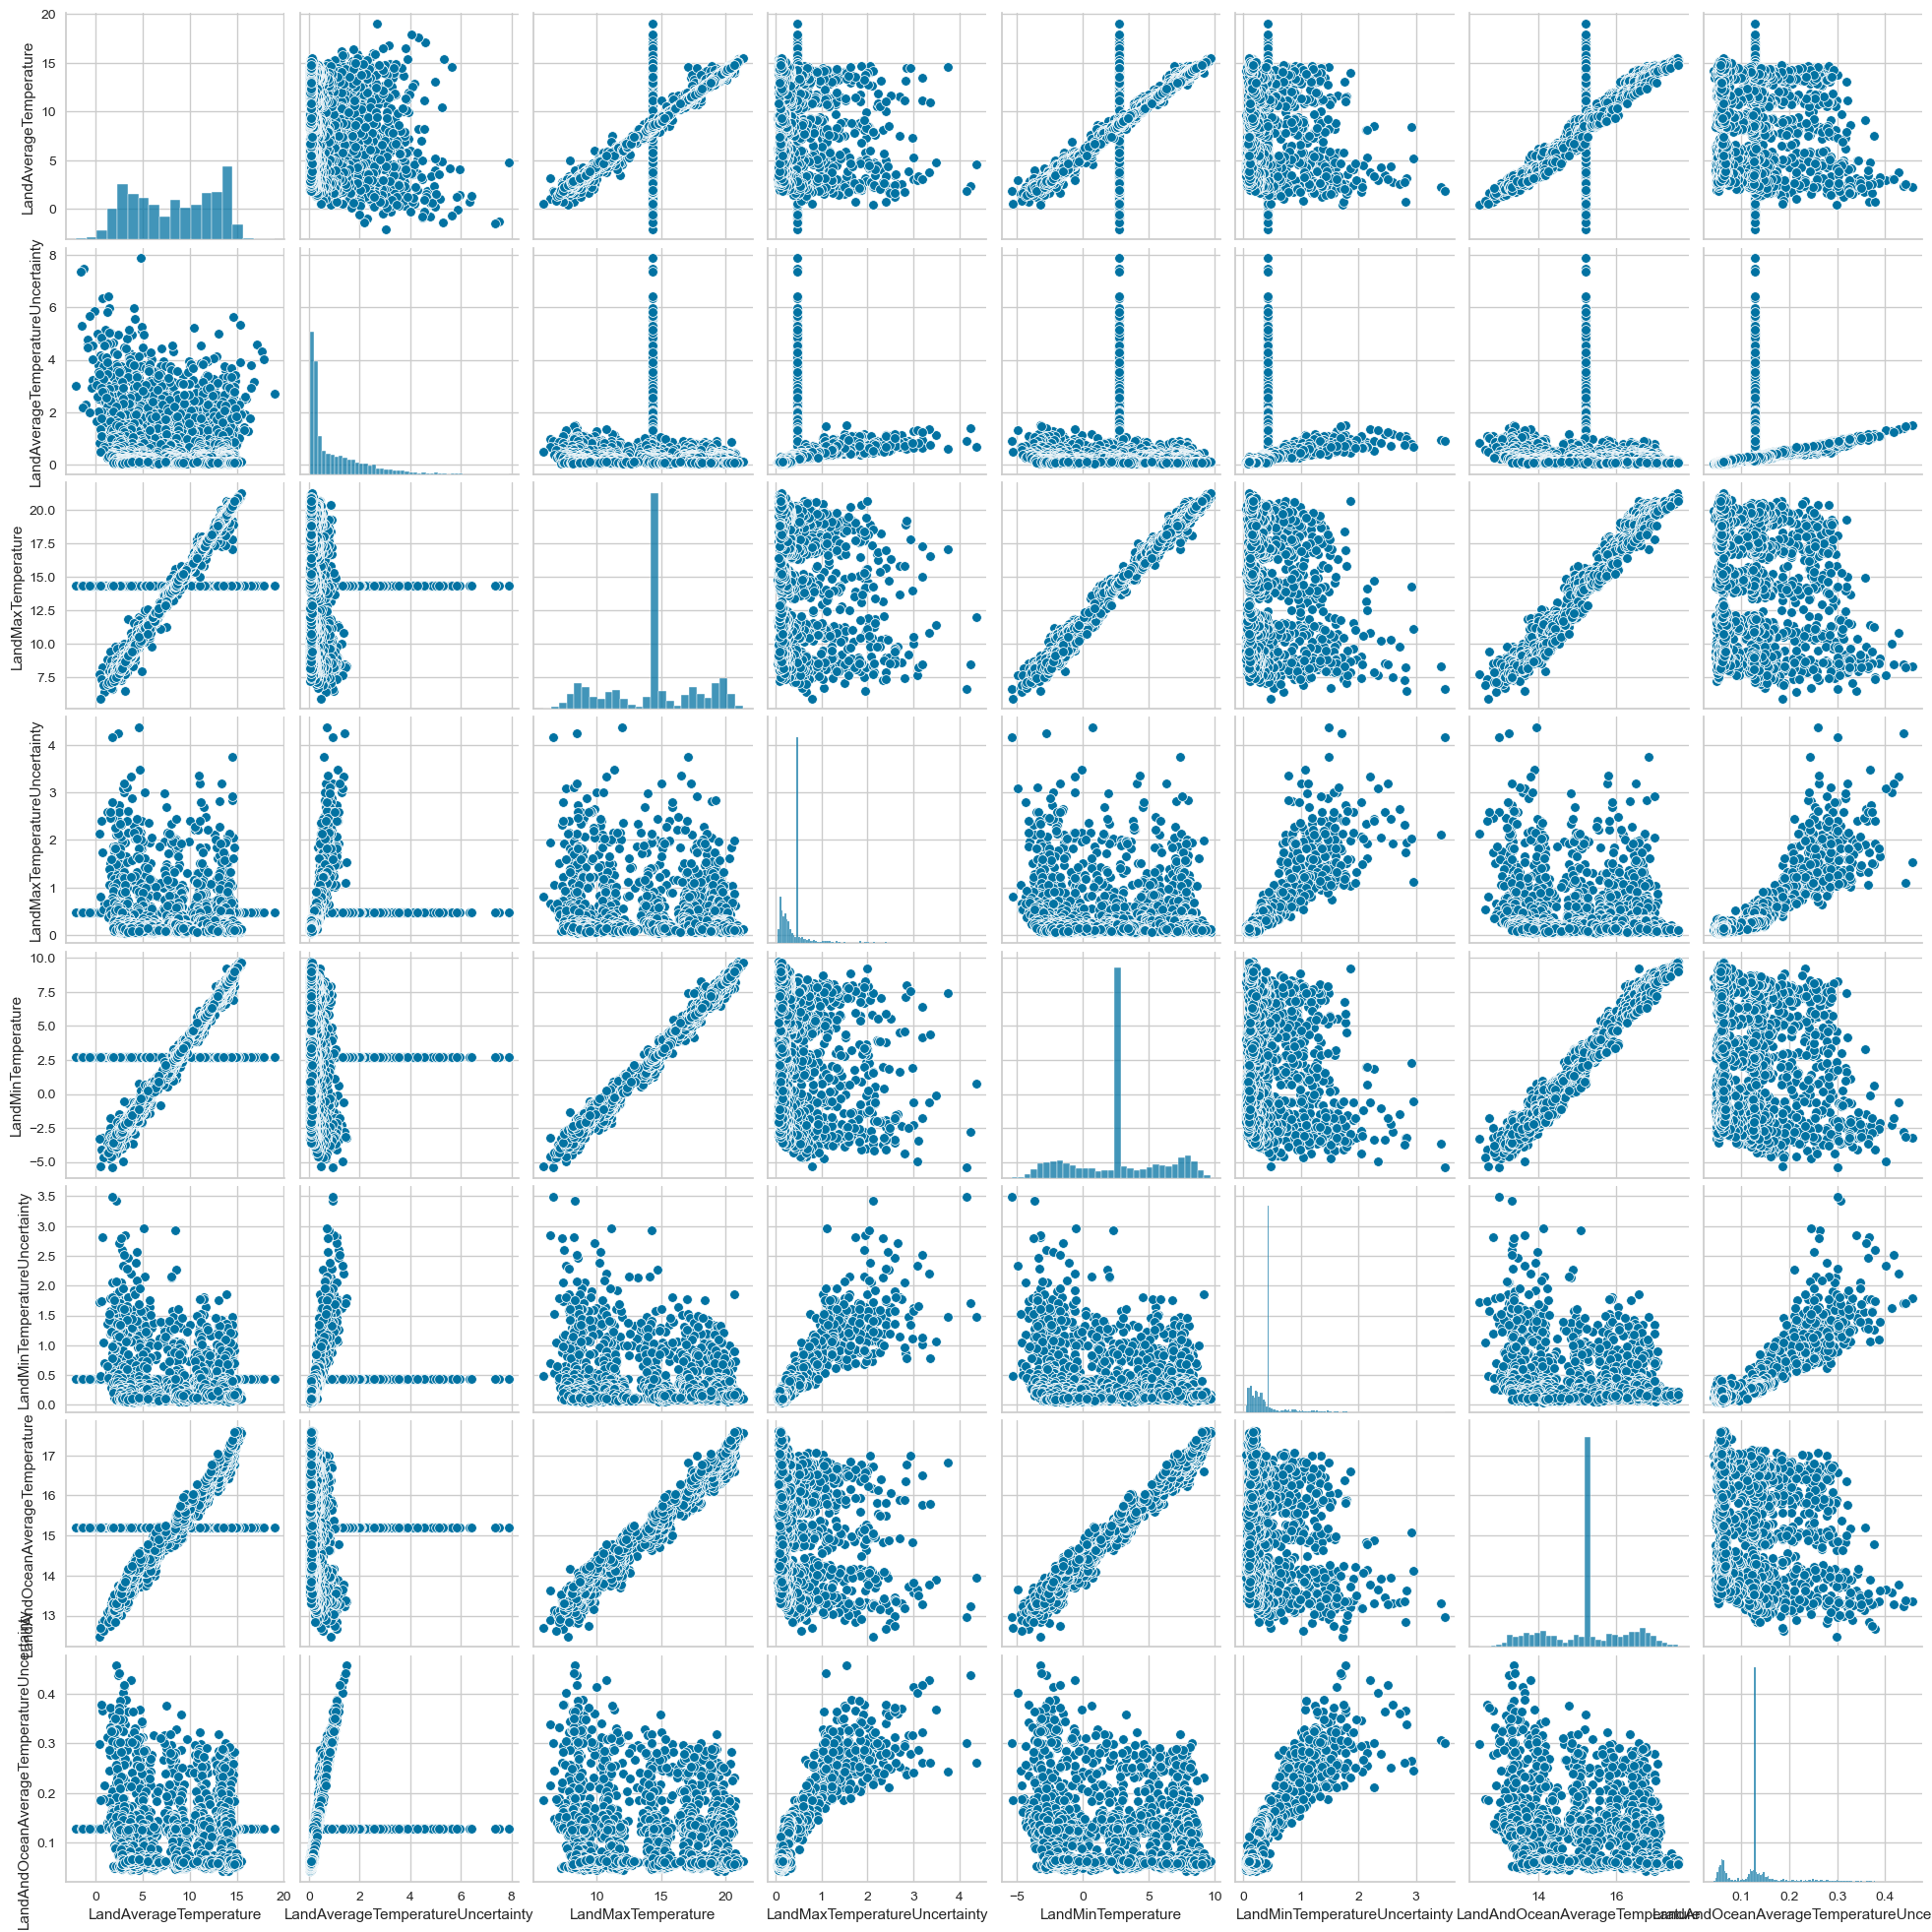

In [21]:
sns.pairplot(data)

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

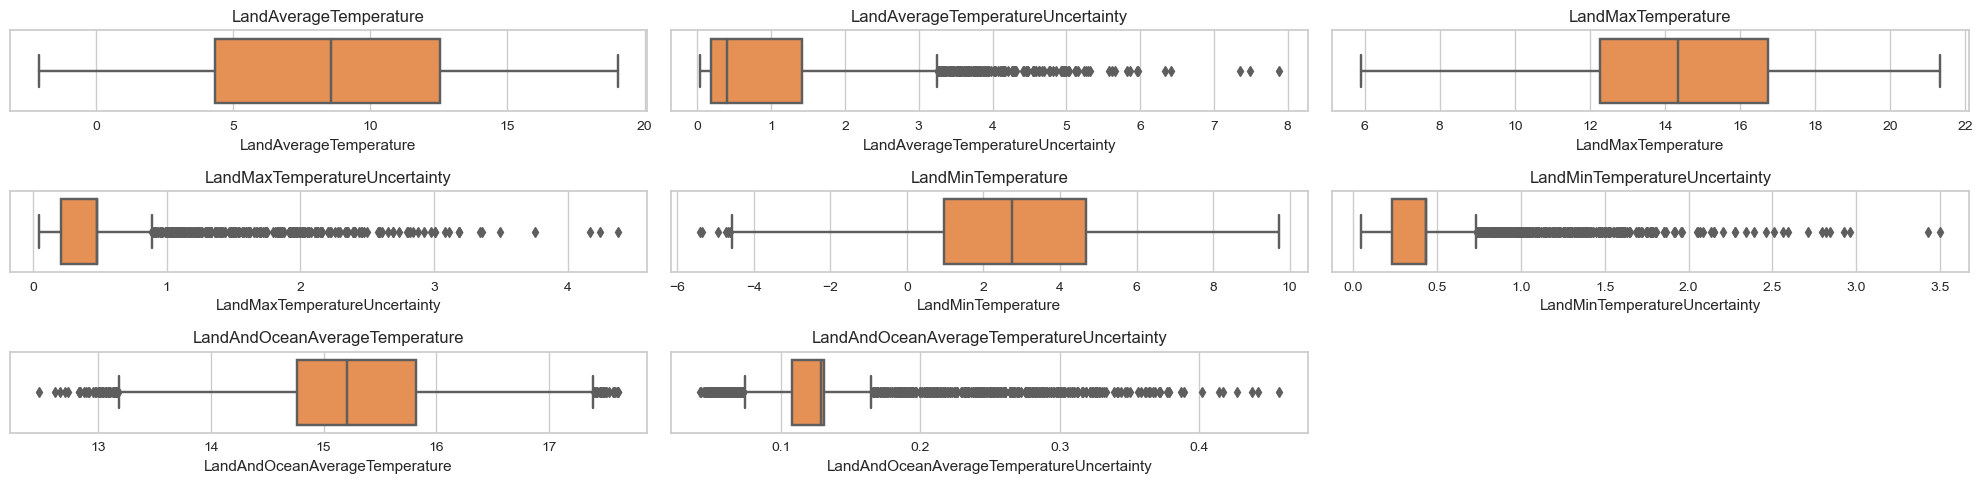

In [22]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

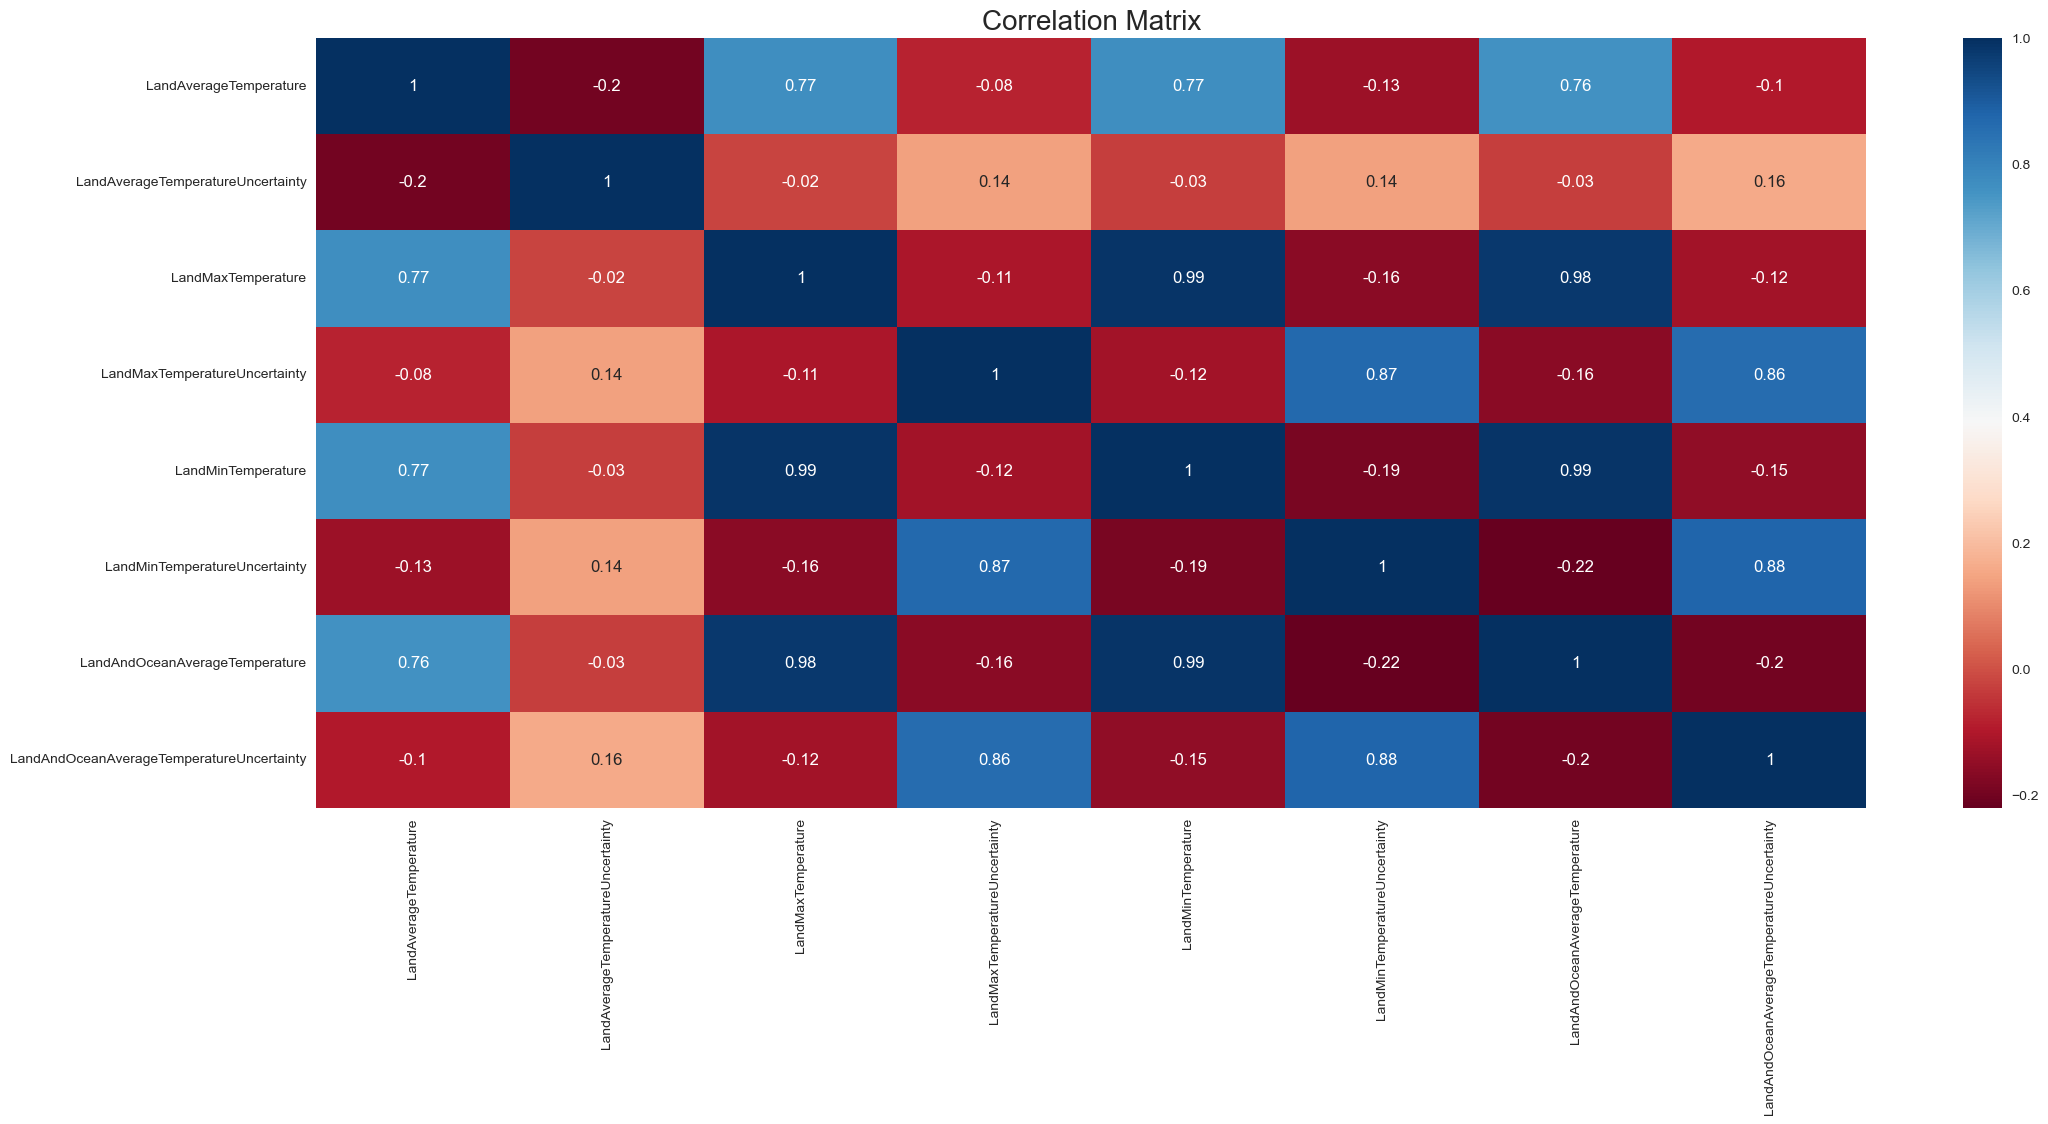

In [26]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [52]:
X = data.drop(columns=['LandAndOceanAverageTemperature'])
Y = data['LandAndOceanAverageTemperature']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = RobustScaler()
X = scaler.fit_transform(X)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(2240, 7) (2240,)
(632, 7) (632,)
(320, 7) (320,)


# 5. Neural Network Algoritms

In [56]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_01)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              8192      
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 287,105
Trainable params: 287,105
Non-trainable params: 0
_________________________________________________________________


In [61]:
num_epoch = 100
batch_size = 32

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/100
70/70 - 0s - loss: 0.4576 - mse: 0.0366 - val_loss: 0.4567 - val_mse: 0.0362 - 429ms/epoch - 6ms/step
Epoch 2/100
70/70 - 0s - loss: 0.4547 - mse: 0.0348 - val_loss: 0.4542 - val_mse: 0.0349 - 173ms/epoch - 2ms/step
Epoch 3/100
70/70 - 0s - loss: 0.4532 - mse: 0.0344 - val_loss: 0.4528 - val_mse: 0.0346 - 157ms/epoch - 2ms/step
Epoch 4/100
70/70 - 0s - loss: 0.4519 - mse: 0.0343 - val_loss: 0.4506 - val_mse: 0.0335 - 167ms/epoch - 2ms/step
Epoch 5/100
70/70 - 0s - loss: 0.4501 - mse: 0.0336 - val_loss: 0.4497 - val_mse: 0.0338 - 158ms/epoch - 2ms/step
Epoch 6/100
70/70 - 0s - loss: 0.4480 - mse: 0.0327 - val_loss: 0.4482 - val_mse: 0.0334 - 167ms/epoch - 2ms/step
Epoch 7/100
70/70 - 0s - loss: 0.4465 - mse: 0.0323 - val_loss: 0.4460 - val_mse: 0.0324 - 160ms/epoch - 2ms/step
Epoch 8/100
70/70 - 0s - loss: 0.4448 - mse: 0.0318 - val_loss: 0.4453 - val_mse: 0.0328 - 166ms/epoch - 2ms/step
Epoch 9/100
70/70 - 0s - loss: 0.4431 - mse: 0.0312 - val_loss: 0.4433 - val_mse: 0.0319

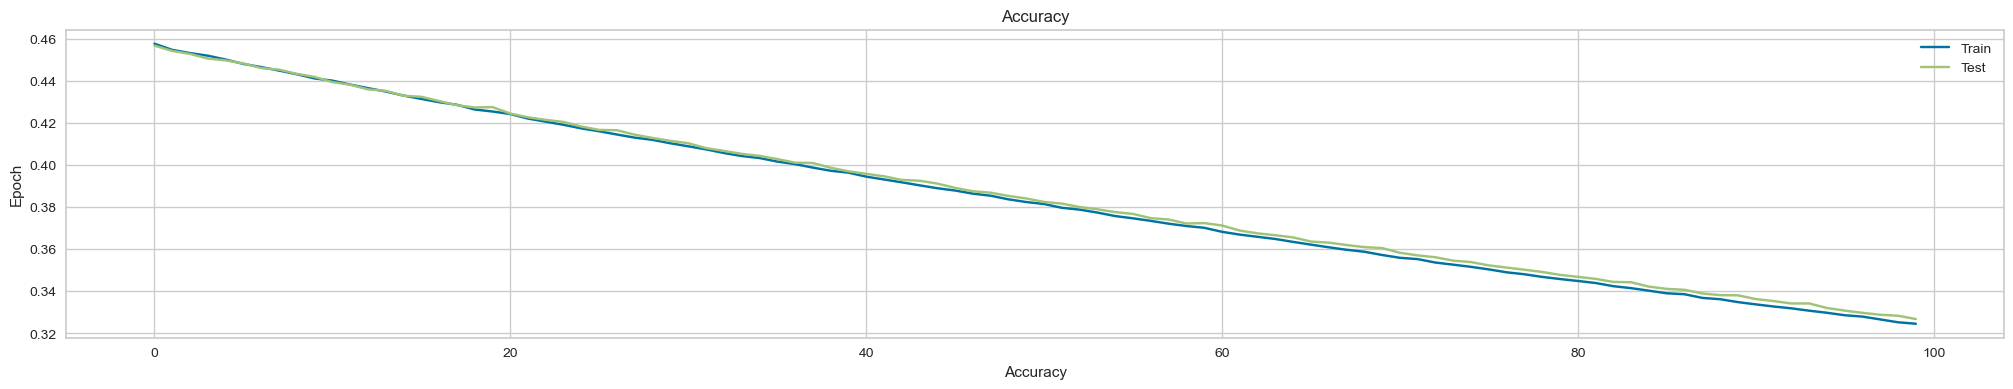

In [62]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [63]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))


R Squared Error    : 0.98
Mean Squared Error : 0.02
Mean Absolute Error: 0.09


In [64]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))

      Train Predictions    Actuals      Diff
1117          15.192554  15.212566  0.020011
2734          14.704592  14.544000  0.160592
2462          14.183679  14.179000  0.004679
2534          14.652419  14.609000  0.043419
2602          14.571790  14.362000  0.209790
0.08745241560035923 / 55.26992665942703


# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [48]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('knn', knn),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    # ('gradient', gradient),
], n_jobs=-1)

In [49]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42))],
                  n_jobs=-1)

In [50]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 99.98 %
Test Score         : 98.92 %
R Squared Error    : 0.99
Mean Squared Error : 0.01
Mean Absolute Error: 0.07


In [51]:
train_predictions = (model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))

      Train Predictions    Actuals      Diff
1117          15.210909  15.212566  0.001657
2734          14.619388  14.544000  0.075388
2462          14.190989  14.179000  0.011989
2534          14.631812  14.609000  0.022812
2602          14.609377  14.362000  0.247377
0.06622526803675466 / 41.85436939922894


### 6.2. Pycarets

In [13]:
s = RegressionExperiment()
s.setup(data, target = 'price', session_id = 123)

In [14]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:24:29
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)

In [16]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,284.1660,292688.2905,541.0067,0.9817,0.1070,0.0831


,carat,cut,color,clarity,depth,table,x,y,z,price,prediction_label
47295,0.30,1,2,3,63.400002,56.0,4.26,4.29,2.71,394,486.420649
52309,0.31,2,0,2,62.299999,56.0,4.32,4.35,2.70,548,682.183706
3825,0.73,2,1,4,61.400002,55.0,5.80,5.82,3.57,3471,3510.702591
45257,0.51,2,2,5,61.599998,57.0,5.14,5.15,3.17,1661,1652.668495
8585,1.01,4,5,5,61.299999,56.0,6.53,6.45,3.98,4438,4476.470241
...,...,...,...,...,...,...,...,...,...,...,...
13768,1.35,4,6,2,61.099998,61.0,7.10,7.13,4.35,5613,5533.372564
46340,0.50,1,0,5,63.700001,56.0,5.09,5.05,3.23,1758,1613.025171
47227,0.60,2,0,2,62.299999,57.0,5.42,5.37,3.36,1840,1804.547772
22661,1.26,2,2,5,61.500000,56.0,6.97,7.01,4.30,10709,9923.811775
